# Face-to-BMI
***
## Machine Learning II

By Amulya Jayanti | Halleluya Mengesha | Hira Stanley | Sami Naeem | Vaishnavi Kokadwar
  
*May, 2025*
***

# PART 2 - Models

## e) ResNet50

#### Data Loading

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set seed
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/BMI'
print("BMI folder contains:", os.listdir(base_dir))

images_dir = os.path.join(base_dir, 'Images')
csv_path = os.path.join(base_dir, 'data.csv')

BMI folder contains: ['data.csv', 'Images', 'BMI_ResNet50.ipynb']


In [5]:
# Load CSV and build a full‐path column
df = pd.read_csv(csv_path)
df['filepath'] = df['name'].apply(lambda fn: os.path.join(images_dir, fn))

# Print counts BEFORE filtering
n_train_before = (df['is_training'] == 1).sum()
n_test_before  = (df['is_training'] == 0).sum()
print(f"Before filtering: {n_train_before} train, {n_test_before} test records in CSV")

Before filtering: 3368 train, 838 test records in CSV


In [6]:
# Filter out rows whose file doesn’t exist
df = df[df['filepath'].apply(os.path.exists)].reset_index(drop=True)

# Print counts AFTER filtering
n_train_after = (df['is_training'] == 1).sum()
n_test_after  = (df['is_training'] == 0).sum()
print(f"After filtering:  {n_train_after} train, {n_test_after} test records with actual .bmp files")

After filtering:  3210 train, 752 test records with actual .bmp files


In [7]:
# Train/test split
train_df = df[df['is_training'] == 1]
test_df  = df[df['is_training'] == 0]

In [8]:
# Extract path and labels

train_paths  = train_df['filepath'].tolist()
train_labels = train_df['bmi'].values
test_paths   = test_df['filepath'].tolist()
test_labels  = test_df['bmi'].values

In [9]:
# --- 3) Params & AUTOTUNE ---
batch_size = 32
img_size   = (224, 224)
AUTOTUNE   = tf.data.AUTOTUNE

In [10]:
def process_path(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_bmp(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_size)
    return img, label

In [11]:
# Build tf.data pipelines
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
      .map(process_path, num_parallel_calls=AUTOTUNE)
      .shuffle(len(train_paths))
      .batch(batch_size)
      .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
      .map(process_path, num_parallel_calls=AUTOTUNE)
      .batch(batch_size)
      .prefetch(AUTOTUNE)
)

In [ ]:
for imgs, bmis in train_ds.take(1):
    print("Batch image shape:", imgs.shape)
    print("Batch label shape:", bmis.shape)

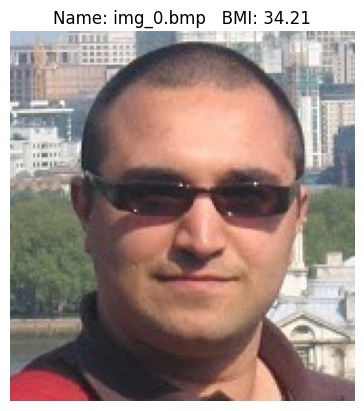

In [12]:
# Print example with associated data

example_path = train_paths[0]
example_bmi  = train_labels[0]

# Load and display
img = plt.imread(example_path)
plt.imshow(img)
plt.title(f"Name: {os.path.basename(example_path)}   BMI: {example_bmi:.2f}")
plt.axis('off')
plt.show()

## ResNet Baseline

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [14]:
# 1) Build the transfer‐learning model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Add regression head
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='linear')(x)   # predict a single BMI value

model = Model(inputs, outputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [15]:
# 2) Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
# 3) Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [ ]:
# 4) Train
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 377s 662ms/step - loss: 1041.2522 - mae: 31.2342 - val_loss: 1039.2274 - val_mae: 30.8907 - learning_rate: 1.0000e-04
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 904.0894 - mae: 28.9669 - val_loss: 910.9134 - val_mae: 28.7367 - learning_rate: 1.0000e-04
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 786.0662 - mae: 26.8486 - val_loss: 795.9699 - val_mae: 26.6593 - learning_rate: 1.0000e-04
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 690.7150 - mae: 25.0079 - val_loss: 693.8063 - val_mae: 24.6661 - learning_rate: 1.0000e-04
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 596.7422 - mae: 23.0914 - val_loss: 603.6308 - val_mae: 22.7618 - learning_rate: 1.0000e-04
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 506.9121 - mae: 21.0178 - val_loss: 524.3139 - val_mae: 20.9438 - learning_rate: 1.0000e-04
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 426.7468 -

## ResNet Fine Tune
* Added simple data augmentation
* Unfroze more layers in ResNet to train
* Lowered learning rate from 1e-4 to 1e-5

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# 1) Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
])

# 2) Build fine-tuning model with augmentation
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True
# Freeze all layers up to the last convolutional block
# ResNet50 has 175 layers; train last 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='linear')(x)
fine_model = Model(inputs, outputs)

# 3) Compile with lower learning rate
fine_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='mse',
    metrics=['mae']
)

# 4) Callbacks (reuse or redefine)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# 5) Fine-tune for 15 epochs
fine_history = fine_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=callbacks
)

# 6) Plot learning curves
plt.figure()
plt.plot(fine_history.history['loss'], label='train_loss')
plt.plot(fine_history.history['val_loss'], label='val_loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.figure()
plt.plot(fine_history.history['mae'], label='train_mae')
plt.plot(fine_history.history['val_mae'], label='val_mae')
plt.title('Training vs. Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

Epoch 1/15


## ResNet Fine Tune
* Adding more data augmentation
* Unfreezing more layers in ResNet
* Lowering learning rate even more to 5e-6
* L2 regularizer added to dense layer

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 354s 624ms/step - loss: 975.8167 - mae: 30.0882 - val_loss: 1171.4133 - val_mae: 32.9609 - learning_rate: 5.0000e-06
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 537.2241 - mae: 21.5944 - val_loss: 780.5435 - val_mae: 26.3700 - learning_rate: 5.0000e-06
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 334.4145 - mae: 16.2208 - val_loss: 391.6404 - val_mae: 17.4891 - learning_rate: 5.0000e-06
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 230.2027 - mae: 12.6824 - val_loss: 261.4290 - val_mae: 13.2743 - learning_rate: 5.0000e-06
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 172.3185 - mae: 10.4384 - val_loss: 201.1415 - val_mae: 10.9628 - learning_rate: 5.0000e-06
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 128.6870 - mae: 8.5163 - val_loss: 167.4699 - val_mae: 9.6254 - learning_rate: 5.0000e-06
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 101.5312 - ma

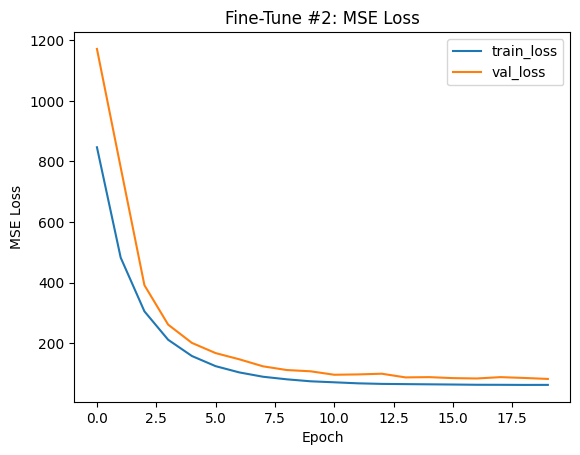

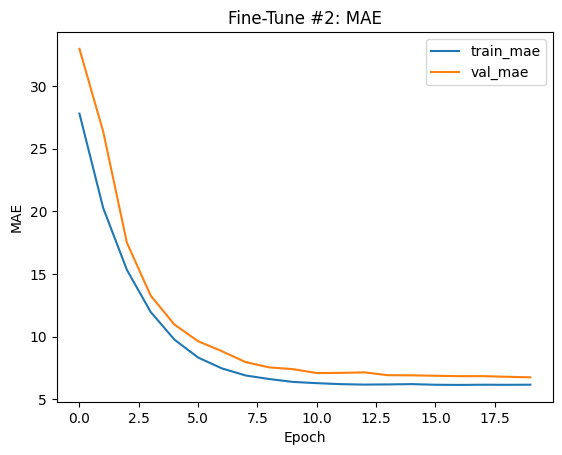

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# 1) Stronger data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
])

# 2) Unfreeze more layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True
# Freeze all layers except the last 25
for layer in base_model.layers[:-25]:
    layer.trainable = False

# 3) Build fine-tune model with L2 regularization
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
# Add L2 weight decay to the Dense layer
outputs = layers.Dense(
    1, activation='linear',
    kernel_regularizer=regularizers.l2(1e-4)
)(x)

fine_model = Model(inputs, outputs)

# 4) Compile model
fine_model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='mse',
    metrics=['mae']
)

# 5) Callbacks (reuse or redefine)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# 6) Fine-tune for 15 epochs
fine_history_2 = fine_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)

# 7) Plot learning curves
plt.figure()
plt.plot(fine_history_2.history['loss'], label='train_loss')
plt.plot(fine_history_2.history['val_loss'], label='val_loss')
plt.title('Fine-Tune #2: MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.figure()
plt.plot(fine_history_2.history['mae'], label='train_mae')
plt.plot(fine_history_2.history['val_mae'], label='val_mae')
plt.title('Fine-Tune #2: MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

## ResNet as a feature extractor to plug into Regressors

In [18]:
print("Layer: -3 →", fine_model.layers[-3])
print("Layer: -2 →", fine_model.layers[-2])
print("Layer: -1 →", fine_model.layers[-1])

Layer: -3 → <GlobalAveragePooling2D name=global_average_pooling2d_1, built=True>
Layer: -2 → <Dropout name=dropout_1, built=True>
Layer: -1 → <Dense name=dense_1, built=True>


In [19]:
import numpy as np
from tensorflow.keras.models import Model

# 1) Build a feature-extractor model whose output is the GAP layer
feat_model = Model(
    inputs = fine_model.input,
    outputs= fine_model.layers[-3].output
)

# 2) Helper to pull out features + labels as NumPy
def extract_features(ds, model):
    X_parts, y_parts = [], []
    for batch_X, batch_y in ds:
        feats = model.predict(batch_X, verbose=0)
        X_parts.append(feats)
        y_parts.append(batch_y.numpy())
    return np.vstack(X_parts), np.concatenate(y_parts)

X_train, y_train = extract_features(train_ds, feat_model)
X_test,  y_test  = extract_features(test_ds,  feat_model)

In [22]:
#!pip install catboost

In [23]:
# 3) Initialize regressors
from sklearn.linear_model    import Ridge
from sklearn.ensemble        import RandomForestRegressor
from sklearn.svm             import SVR
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.neural_network  import MLPRegressor
from xgboost                 import XGBRegressor
from lightgbm                import LGBMRegressor
from catboost                import CatBoostRegressor

regs = {
    'Ridge':  Ridge(alpha=1.0),
    'RF':     RandomForestRegressor(n_estimators=100, random_state=0),
    'SVR':    SVR(kernel='rbf', C=1.0),
    'KNN':    KNeighborsRegressor(n_neighbors=5),
    'MLP':    MLPRegressor(hidden_layer_sizes=(64,32), max_iter=200, random_state=0),
    'XGBoost':XGBRegressor(learning_rate=0.05, n_estimators=100, random_state=0),
    'LightGBM':LGBMRegressor(learning_rate=0.05, n_estimators=100, random_state=0),
    'CatBoost':CatBoostRegressor(verbose=0, random_state=0)
}

In [24]:
# 4) Train & evaluate each
from sklearn.metrics import mean_absolute_error

results = {}
for name, reg in regs.items():
    reg.fit(X_train, y_train)
    preds = reg.predict(X_test)
    mae   = mean_absolute_error(y_test, preds)
    results[name] = mae
    print(f"{name:10s} MAE = {mae:.2f}")

Ridge      MAE = 6.39
RF         MAE = 6.41
SVR        MAE = 6.60
KNN        MAE = 7.01
MLP        MAE = 6.41
XGBoost    MAE = 6.31


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514859
[LightGBM] [Info] Number of data points in the train set: 3210, number of used features: 2048
[LightGBM] [Info] Start training from score 32.434370


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM   MAE = 6.35
CatBoost   MAE = 6.29


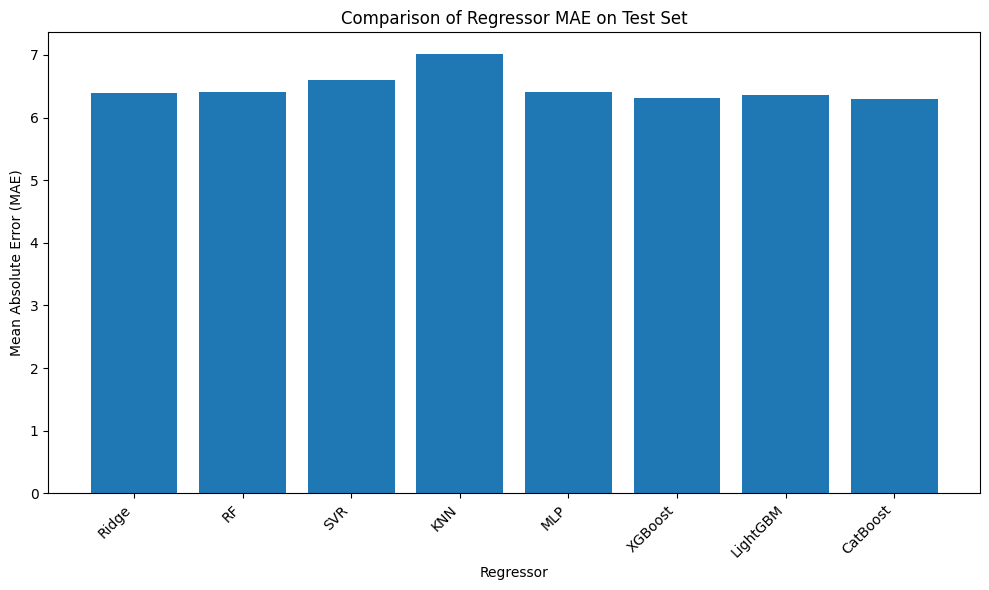

In [25]:
# 5) Plot results
names = list(results.keys())
maes  = list(results.values())

plt.figure(figsize=(10, 6))
plt.bar(names, maes)
plt.xlabel('Regressor')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of Regressor MAE on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [26]:
# 5) Ensemble the top performers
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error

# Ensemble the top 3 regressors by lowest MAE: XGBoost, Ridge, CatBoost
top3 = [
    ('xgb',   regs['XGBoost']),
    ('ridge', regs['Ridge']),
    ('cat',   regs['CatBoost'])
]
ensemble = VotingRegressor(top3)
ensemble.fit(X_train, y_train)
ens_mae = mean_absolute_error(y_test, ensemble.predict(X_test))
print(f"\nEnsemble MAE = {ens_mae:.2f}")


Ensemble MAE = 6.17


In [27]:
from scipy.stats import pearsonr

# 1) Pearson r for each individual regressor
print("Individual model Pearson correlations:")
for name, model in regs.items():
    preds = model.predict(X_test)
    r, _  = pearsonr(y_test, preds)
    print(f"{name:12s} Pearson r = {r:.3f}")

# 2) Pearson r for the ensemble
ensemble_preds = ensemble.predict(X_test)
r_ens, _       = pearsonr(y_test, ensemble_preds)
print(f"\n{'Ensemble':12s} Pearson r = {r_ens:.3f}")

Individual model Pearson correlations:
Ridge        Pearson r = 0.384
RF           Pearson r = 0.337
SVR          Pearson r = 0.315
KNN          Pearson r = 0.215
MLP          Pearson r = 0.359
XGBoost      Pearson r = 0.356
LightGBM     Pearson r = 0.356
CatBoost     Pearson r = 0.372

Ensemble     Pearson r = 0.409


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Train with Gender

In [28]:
df.head()

,Unnamed: 0,bmi,gender,is_training,name,filepath
0,0,34.207396,Male,1,img_0.bmp,/content/drive/MyDrive/Colab Notebooks/BMI/Ima...
1,1,26.453720,Male,1,img_1.bmp,/content/drive/MyDrive/Colab Notebooks/BMI/Ima...
2,2,34.967561,Female,1,img_2.bmp,/content/drive/MyDrive/Colab Notebooks/BMI/Ima...
3,3,22.044766,Female,1,img_3.bmp,/content/drive/MyDrive/Colab Notebooks/BMI/Ima...
4,6,25.845588,Female,1,img_6.bmp,/content/drive/MyDrive/Colab Notebooks/BMI/Ima...


In [29]:
# 1) Absolute counts
gender_counts = df['gender'].value_counts()
print("Gender counts:")
print(gender_counts)

# 2) Percentages
gender_percent = df['gender'].value_counts(normalize=True) * 100
print("\nGender distribution (%):")
print(gender_percent.round(2))

Gender counts:
gender
Male      2354
Female    1608
Name: count, dtype: int64

Gender distribution (%):
gender
Male      59.41
Female    40.59
Name: proportion, dtype: float64


**Next code block:**
* Encodes gender as a numeric feature (0/1).
* Extends tf.data pipeline so each batch yields (images, genders) alongside BMI.
* Defines a two-input model that processes the image through ResNet50, then concatenates the gender scalar before the final Dense head.
* Trains it the same way, now giving the network demographic context that can boost Pearson correlation toward that 0.65 benchmark.

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, callbacks

# 1) Encode gender as 0/1
gender_map = {'Male': 0, 'Female': 1}
train_genders = train_df['gender'].map(gender_map).values
test_genders  = test_df['gender'].map(gender_map).values

# 2) Build a tf.data.Dataset that yields ((image, gender), bmi)
def make_ds(paths, genders, bmis, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, genders, bmis))
    if shuffle:
        ds = ds.shuffle(len(paths))
    ds = ds.map(lambda p, g, y: (
                (*process_path(p, y)[:1], tf.expand_dims(g,0)),  # (img, gender)
                y
            ),
            num_parallel_calls=tf.data.AUTOTUNE
         )
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds2 = make_ds(train_paths, train_genders, train_labels, shuffle=True)
test_ds2  = make_ds(test_paths,  test_genders,  test_labels)

# 3) Build a two-input model
img_in   = layers.Input(shape=(224,224,3), name='image_input')
gender_in= layers.Input(shape=(1,), name='gender_input')

# image branch
x = base_model(img_in, training=False)
x = layers.GlobalAveragePooling2D()(x)

# concatenate gender
x = layers.Concatenate()([x, gender_in])
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation='linear')(x)

model2 = Model([img_in, gender_in], out)

model2.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

# 4) Train
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history2 = model2.fit(
    train_ds2,
    validation_data=test_ds2,
    epochs=20,
    callbacks=[es, rl]
)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 35s 178ms/step - loss: 412.1042 - mae: 16.2007 - val_loss: 90.7530 - val_mae: 6.8206 - learning_rate: 1.0000e-04
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 56.9472 - mae: 5.8470 - val_loss: 94.9834 - val_mae: 6.8796 - learning_rate: 1.0000e-04
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 52.3925 - mae: 5.6329 - val_loss: 72.5541 - val_mae: 6.2758 - learning_rate: 1.0000e-04
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 50.4425 - mae: 5.5133 - val_loss: 181.9034 - val_mae: 11.8500 - learning_rate: 1.0000e-04
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 50.8622 - mae: 5.4920 - val_loss: 71.0615 - val_mae: 6.4663 - learning_rate: 1.0000e-04
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 49.0536 - mae: 5.4863 - val_loss: 74.8000 - val_mae: 6.4942 - learning_rate: 1.0000e-04
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 46.0814 - mae: 5.2629 - val_loss: 78.73

In [31]:
from scipy.stats import pearsonr
import numpy as np

# Accumulate predictions, true BMIs, and gender flags
preds_list, truths_list, genders_list = [], [], []
for (img_batch, gen_batch), y_batch in test_ds2:
    batch_preds = model2.predict([img_batch, gen_batch], verbose=0).flatten()
    preds_list.append(batch_preds)
    truths_list.append(y_batch.numpy())
    genders_list.append(gen_batch.numpy().flatten())

preds   = np.concatenate(preds_list)
truths  = np.concatenate(truths_list)
genders = np.concatenate(genders_list)  # 0=Male, 1=Female

# Compute Pearson r by gender
for gender_label, mask in [('Male', genders == 0), ('Female', genders == 1)]:
    r, p = pearsonr(truths[mask], preds[mask])
    print(f"{gender_label:6s} → Pearson r = {r:.3f}, p-value = {p:.2e}")

Male   → Pearson r = 0.450, p-value = 1.04e-22
Female → Pearson r = 0.384, p-value = 7.88e-13


## Extract features and train regressors with Gender

In [32]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 1) Extract features + gender into NumPy arrays
def extract_features_and_gender(ds, feat_model):
    feats_list, gender_list, y_list = [], [], []
    for (img_batch, gen_batch), y_batch in ds:
        feats = feat_model.predict(img_batch, verbose=0)
        feats_list.append(feats)
        gender_list.append(gen_batch.numpy().reshape(-1,1))
        y_list.append(y_batch.numpy())
    X_feats  = np.vstack(feats_list)
    G        = np.vstack(gender_list)
    y        = np.concatenate(y_list)
    return np.hstack([X_feats, G]), y

X_train_g, y_train = extract_features_and_gender(train_ds2, feat_model)
X_test_g,  y_test  = extract_features_and_gender(test_ds2,  feat_model)

# 2) Define regressors
regs = {
    'Ridge':     Ridge(alpha=1.0),
    'RF':        RandomForestRegressor(n_estimators=100, random_state=0),
    'SVR':       SVR(kernel='rbf', C=1.0),
    'KNN':       KNeighborsRegressor(n_neighbors=5),
    'MLP':       MLPRegressor(hidden_layer_sizes=(64,32), max_iter=200, random_state=0),
    'XGBoost':   XGBRegressor(learning_rate=0.05, n_estimators=100, random_state=0),
    'LightGBM':  LGBMRegressor(learning_rate=0.05, n_estimators=100, random_state=0),
    'CatBoost':  CatBoostRegressor(verbose=0, random_state=0)
}

# 3) Train each regressor and print Pearson correlation
print("Individual model Pearson correlations (with gender):")
for name, reg in regs.items():
    reg.fit(X_train_g, y_train)
    preds = reg.predict(X_test_g)
    r, _  = pearsonr(y_test, preds)
    print(f"{name:12s} Pearson r = {r:.3f}")

# 4) Ensemble top 3 regressors by prior performance
ensemble = VotingRegressor([
    ('xgb',   regs['XGBoost']),
    ('ridge', regs['Ridge']),
    ('cat',   regs['CatBoost'])
])
ensemble.fit(X_train_g, y_train)
r_ens, _ = pearsonr(y_test, ensemble.predict(X_test_g))
print(f"\n{'Ensemble':12s} Pearson r = {r_ens:.3f}")

Individual model Pearson correlations (with gender):
Ridge        Pearson r = 0.441
RF           Pearson r = 0.438
SVR          Pearson r = 0.440
KNN          Pearson r = 0.369
MLP          Pearson r = 0.442
XGBoost      Pearson r = 0.445


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503806
[LightGBM] [Info] Number of data points in the train set: 3210, number of used features: 2048
[LightGBM] [Info] Start training from score 32.434370


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM     Pearson r = 0.441
CatBoost     Pearson r = 0.438

Ensemble     Pearson r = 0.459


In [33]:
# Compute Mean Absolute Error for each model and the ensemble
from sklearn.metrics import mean_absolute_error

print("Individual model MAE (with gender):")
for name, reg in regs.items():
    preds = reg.predict(X_test_g)
    mae = mean_absolute_error(y_test, preds)
    print(f"{name:12s} MAE = {mae:.3f}")

# Ensemble MAE
mae_ens = mean_absolute_error(y_test, ensemble.predict(X_test_g))
print(f"\n{'Ensemble':12s} MAE = {mae_ens:.3f}")

Individual model MAE (with gender):
Ridge        MAE = 6.122
RF           MAE = 6.083
SVR          MAE = 6.081
KNN          MAE = 6.491
MLP          MAE = 6.270
XGBoost      MAE = 6.063
LightGBM     MAE = 6.112


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CatBoost     MAE = 6.066

Ensemble     MAE = 6.000


In [34]:
# Pearson correlation by gender for the ensemble
from scipy.stats import pearsonr

preds_ens = ensemble.predict(X_test_g)
genders = X_test_g[:, -1]  # assumes last column is gender encoded as 0/1

for label, value in [('Female', 0), ('Male', 1)]:
    mask = genders == value
    r, _ = pearsonr(y_test[mask], preds_ens[mask])
    print(f"{label:6s} Pearson r = {r:.3f}")

Female Pearson r = 0.504
Male   Pearson r = 0.400
